# Prepare some things
## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics

import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../')
from models import compute_p, compute_delta, get_dec_model
from clustering_metrics import evaluate_clustering
from draw_embeddings import draw_multiple_labels

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load the metabolomic data
(alrady min-max normalized)

In [4]:
metabol_exprs = pd.read_csv("ExposomeChallengeData/datasets/metabol_joint_exprs_minmax.csv", index_col=0)
metabol_exprs.head()

,serum_metab_1,serum_metab_2,serum_metab_3,serum_metab_4,serum_metab_5,serum_metab_6,serum_metab_7,serum_metab_8,serum_metab_9,serum_metab_10,...,urine_metab_35,urine_metab_36,urine_metab_37,urine_metab_38,urine_metab_39,urine_metab_40,urine_metab_41,urine_metab_42,urine_metab_43,urine_metab_44
430,0.224542,0.205024,0.490470,0.653163,0.515652,0.483009,0.249523,0.340524,0.400406,0.574663,...,0.485001,0.628204,0.489431,0.640612,0.391376,0.665946,0.848047,0.360177,0.587031,0.605114
1187,0.402503,0.549489,0.828354,0.323912,0.431621,0.491824,0.376192,0.348330,0.213731,0.308797,...,0.469040,0.816605,0.441328,0.000000,0.494475,0.696170,0.413698,0.396026,0.572658,0.619732
940,0.402503,0.556896,0.706195,0.534558,0.544173,0.514375,0.397976,0.856991,0.358113,0.315096,...,0.469738,0.627037,0.519383,0.000000,0.326659,0.645060,0.841829,0.000000,0.653218,0.665950
936,0.462293,0.578889,0.451112,0.448921,0.492050,0.553183,0.372429,0.544806,0.388943,0.545676,...,0.457602,0.738061,0.290234,0.177238,0.451808,0.487007,0.759121,0.000000,0.678092,0.729031
788,0.247137,0.571595,0.568414,0.417697,0.432269,0.553183,0.531642,0.534388,0.536561,0.704749,...,0.452021,0.639165,0.329798,0.354477,0.250210,0.702331,0.778121,0.345500,0.554585,0.661642


In [5]:
metabol_exprs = metabol_exprs.to_numpy()
# np.random.shuffle(metabol_exprs)

In [6]:
num_data_points = np.multiply(*metabol_exprs.shape)
print("Shape of the data set:", metabol_exprs.shape)
print("Number of data points:", num_data_points)

Shape of the data set: (1152, 221)
Number of data points: 254592


## Load the categorical variables
(subset of phenotype and covariates data, already codified)

In [7]:
phenotype_cat = pd.read_csv("ExposomeChallengeData/datasets/phenotype_cat.csv", index_col=0)
covariates_cat = pd.read_csv("ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes = pd.concat([phenotype_cat, covariates_cat], axis=1)
classes.head()

,birth_weight,iq,behaviour,asthma,bmi,cohort,age,sex,education,native,parity
1,3,0,3,0,1,3,1,0,1,2,0
2,3,1,3,0,1,3,2,0,2,2,1
3,3,0,3,1,3,3,1,0,2,2,1
4,1,2,3,0,1,1,4,1,0,2,1
5,3,0,1,0,1,2,4,0,0,2,0


In [8]:
print("Number of class variables:", classes.shape[1])

Number of class variables: 11


# DC models with 1D convolutional layers

## Prepare the input
- pad with zeros to have shape 224 (divisible by 2 five times)
- add 1 dimention

In [9]:
metabol_exprs = np.pad(metabol_exprs, ((0,0),(0,3)), 'constant', constant_values=0)
metabol_exprs.shape

(1152, 224)

In [10]:
metabol_exprs = np.expand_dims(metabol_exprs, -1)
metabol_exprs.shape

(1152, 224, 1)

## Prepare the autoencoder

### Construct the model

In [11]:
def get_encoder(input_dim, latent_dim, filters=[], kernel=3):
    encoder_inputs = keras.Input(shape=(input_dim, 1), name="encoder_inputs")
    x = encoder_inputs
    for f in filters:
        x = layers.Conv1D(f, kernel, padding='same', activation="relu") (x)
        x = layers.MaxPool1D(2, padding='same') (x)
    x = layers.Flatten(name="flatten") (x)
    encoder_outputs = layers.Dense(latent_dim, activation="relu", name="z") (x)
    return models.Model(encoder_inputs, encoder_outputs, name="Encoder")
    
def get_decoder(output_dim, latent_dim, filters=[], kernel=3):
    flat_shape = output_dim * filters[-1] // (2*len(filters))
    reshape_shape = (flat_shape//filters[-1], filters[-1])
    
    decoder_inputs = keras.Input(shape=(latent_dim), name="decoder_inputs")
    x = layers.Dense(flat_shape) (decoder_inputs)
    x = layers.Reshape(reshape_shape) (x)
    for f in filters[::-1]:
        x = layers.Conv1DTranspose(f, kernel, strides=2, padding="same") (x)
    decoder_outputs = layers.Conv1D(1, kernel, activation="sigmoid", padding="same", name="recon_x") (x)
    return models.Model(decoder_inputs, decoder_outputs, name="Decoder")

In [12]:
INPUT_DIM = metabol_exprs.shape[1]
FILTERS = (4, 16)
LATENT_DIM = 5

encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS)
encoder.summary()

decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS)
decoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 224, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 224, 4)            16        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 112, 4)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 112, 16)           208       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 896)               0   

In [13]:
z = encoder(encoder.inputs)
ae_outputs = decoder(z)
ae = models.Model(encoder.inputs, ae_outputs)
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 224, 1)]         0         
                                                                 
 Encoder (Functional)        (None, 5)                 4709      
                                                                 
 Decoder (Functional)        (None, 224, 1)            6369      
                                                                 
Total params: 11,078
Trainable params: 11,078
Non-trainable params: 0
_________________________________________________________________


Number of data points / number of parameters ratio:

In [14]:
np.multiply(*metabol_exprs.shape[0:2]) / ae.count_params()

23.293735331287237

### Try different hyperparameters

#### Different kernel sizes

I'll try different numbers of kernel sizes and train an AE multiple times on the metabolomics data, then avarage the results. I'll keep the kernel size that achieves the best relation between data points to parameters ratio and loss result.

In [15]:
INPUT_DIM = metabol_exprs.shape[1]
FILTERS = (4, 16)
LATENT_DIM = 5
KERNELS = (3, 5, 7, 10)

EPOCHS = 50
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for kernel in KERNELS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'kernel size: {kernel}', end=" ")
    
    for i in np.arange(10):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS, kernel)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, kernel)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {np.multiply(*metabol_exprs.shape[0:2]) / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


kernel size: 3 [data ponints / params ratio: 23.29 [loss: 0.0130, val_loss: 0.0141, ratio: 0.9257]
kernel size: 5 [data ponints / params ratio: 21.75 [loss: 0.0136, val_loss: 0.0146, ratio: 0.9307]
kernel size: 7 [data ponints / params ratio: 20.41 [loss: 0.0130, val_loss: 0.0140, ratio: 0.9298]
kernel size: 10 [data ponints / params ratio: 18.67 [loss: 0.0134, val_loss: 0.0144, ratio: 0.9325]


It looks like a kernel size of 3 achieves the best balance.

#### Different numbers of filters

Next, I'll try different numbers of filters. I'll keep the encoder and decoder maximum depth to two layers, since adding more layers would increment the number of parameters and we want to keep it low. 

In [16]:
INPUT_DIM = metabol_exprs.shape[1]
LATENT_DIM = 5
KERNEL = 3
FILTERS = ((4,),
           (4, 4),
           (4, 8),
           (4, 16),
           (4, 32),
           (8,),
           (8, 8),
           (8, 16),
           (8, 32),
           (16,),
           (16, 16),
           (16, 32),
           (32,)
          )

EPOCHS = 50
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for f in FILTERS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'filter numbers: {f}', end=" ")
    
    for i in np.arange(5):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {np.multiply(*metabol_exprs.shape[0:2]) / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


filter numbers: (4,) [data ponints / params ratio: 51.47 [loss: 0.0130, val_loss: 0.0141, ratio: 0.9189]
filter numbers: (4, 4) [data ponints / params ratio: 97.23 [loss: 0.0130, val_loss: 0.0140, ratio: 0.9338]
filter numbers: (4, 8) [data ponints / params ratio: 48.09 [loss: 0.0123, val_loss: 0.0131, ratio: 0.9380]
filter numbers: (4, 16) [data ponints / params ratio: 23.29 [loss: 0.0140, val_loss: 0.0151, ratio: 0.9275]
filter numbers: (4, 32) [data ponints / params ratio: 10.91 [loss: 0.0139, val_loss: 0.0149, ratio: 0.9303]
filter numbers: (8,) [data ponints / params ratio: 25.50 [loss: 0.0135, val_loss: 0.0145, ratio: 0.9251]
filter numbers: (8, 8) [data ponints / params ratio: 46.16 [loss: 0.0131, val_loss: 0.0141, ratio: 0.9294]
filter numbers: (8, 16) [data ponints / params ratio: 22.45 [loss: 0.0131, val_loss: 0.0142, ratio: 0.9249]
filter numbers: (8, 32) [data ponints / params ratio: 10.55 [loss: 0.0129, val_loss: 0.0140, ratio: 0.9241]
filter numbers: (16,) [data ponints /

The combinations (4), (4,4), (4, 8) and (8, 8) keep the data points to parameters ratio relatively high while achieving similar performances. Let's try training them fore more epochs to see if the differences get bigger.

In [17]:
INPUT_DIM = metabol_exprs.shape[1]
LATENT_DIM = 5
KERNEL = 3
FILTERS = ((4,),
           (4, 4),
           (4, 8),
           (8,),
           (8, 8),
          )

EPOCHS = 200
BATCH_SIZE = 32

LEARNING_RATE = 1
MOMENTUM = 0.8
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

for f in FILTERS:
    loss = []
    val_loss = []
    loss_ratio = []
    print(f'filter numbers: {f}', end=" ")
    
    for i in np.arange(5):
        # Construct the autoencoder
        encoder = get_encoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        decoder = get_decoder(INPUT_DIM, LATENT_DIM, f, KERNEL)
        z = encoder(encoder.inputs)
        ae_outputs = decoder(z)
        ae = models.Model(encoder.inputs, ae_outputs)
        if i == 0:
            print(f'[data ponints / params ratio: {np.multiply(*metabol_exprs.shape[0:2]) / ae.count_params():.2f}', end=" ")

        # Train it
        ae.compile(optimizer=optimizer, loss="mse")
        history = ae.fit(metabol_exprs, metabol_exprs,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_split=0.2,
                               verbose=0)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        loss_ratio.append(loss[-1] / val_loss[-1])

    print(f"[loss: {np.mean(loss):.4f}, val_loss: {np.mean(val_loss):.4f}, ratio: {np.mean(loss_ratio):.4f}]")


filter numbers: (4,) [data ponints / params ratio: 51.47 [loss: 0.0121, val_loss: 0.0133, ratio: 0.9128]
filter numbers: (4, 4) [data ponints / params ratio: 97.23 [loss: 0.0127, val_loss: 0.0137, ratio: 0.9244]
filter numbers: (4, 8) [data ponints / params ratio: 48.09 [loss: 0.0116, val_loss: 0.0128, ratio: 0.9093]
filter numbers: (8,) [data ponints / params ratio: 25.50 [loss: 0.0116, val_loss: 0.0127, ratio: 0.9133]
filter numbers: (8, 8) [data ponints / params ratio: 46.16 [loss: 0.0128, val_loss: 0.0139, ratio: 0.9214]


It seems that the simplest configuration (1 convolutional layer with 4 filters) achieves the best loss. It also has one of the best data points to params ratio. I'll use this configuration.

#### Results

I've decided for the following hyperparameters:
- Number of convolutional layers: 1
- Number of filters: 4
- Kernel size: 3

# DEC with 1D convolutional encoder

In [18]:
categorical_variables = {2: ["asthma", "sex"],
                         3: ["education", "native", "parity"],
                         4: ["birth_weight", "iq", "behaviour", "bmi"],
                         6: ["cohort"],
                         7: ["age"]}

true_labels = {}
for k, variables in categorical_variables.items():
    true_labels[k] = {var: classes.loc[:,var] for var in variables}

cluster_labels = []
results = []

In [19]:
INPUT_DIM = metabol_exprs.shape[1]
KERNEL = 7
FILTERS = (4,)

EPOCHS_PRETRAIN = 100
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.8

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-4
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

In [20]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(metabol_exprs)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        # print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

K=2 - Pretraining AE [loss: 0.0154] - Fine-tunning DEC [loss: 2.3011]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.576']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.576']
K=3 - Pretraining AE [loss: 0.0154] - Fine-tunning DEC [loss: 3.9381]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.581']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.581']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.581']
K=4 - Pretraining AE [loss: 0.0138] - Fine-tunning DEC [loss: 5.9776]
birth_weight ['Acc: 0.265', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.435']
iq ['Acc: 0.300', 'ARI: 0.001', 'AMI: 0.001', 'Sil: 0.435']
behaviour ['Acc: 0.273', 'ARI: -0.000', 'AMI: -0.000', 'Sil: 0.435']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.435']
K=6 - Pretraining AE [loss: 0.0126] - Fine-tunning DEC [loss: 8.4563]
cohort ['Acc: 0.210', 'ARI: 0.004', 'AMI: 0.002', 'Sil: 0.278']
K=7 - Pretraining AE [loss: 0.0105] - Fine-tunning DEC [loss: 9.4359]
age 

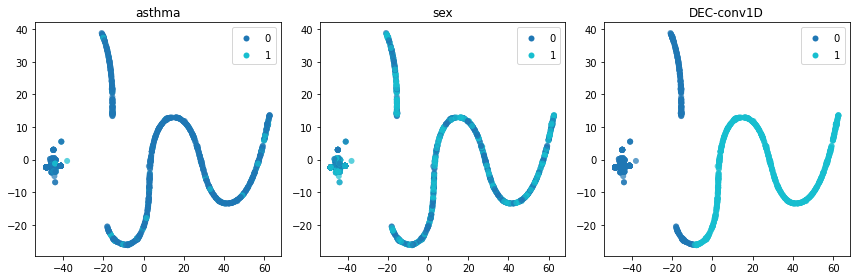

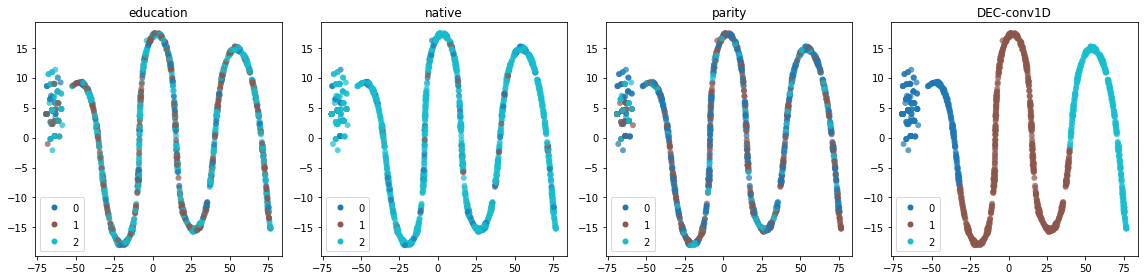

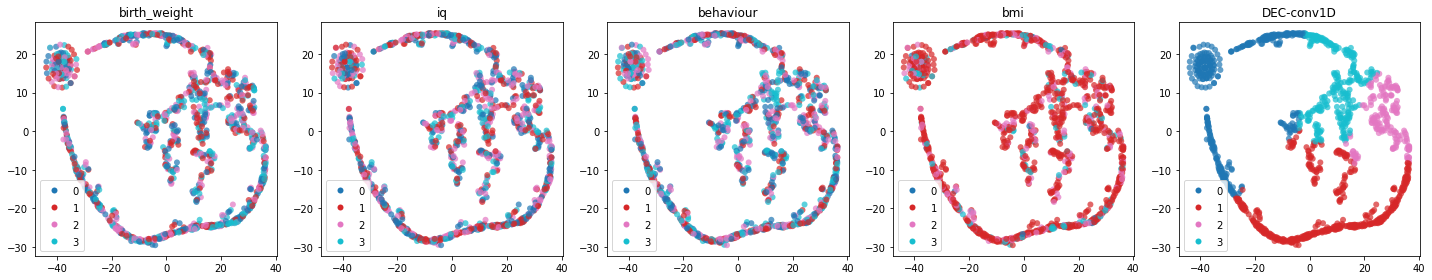

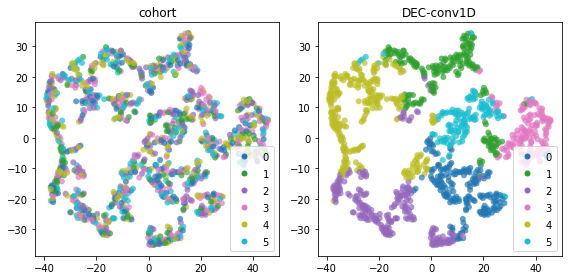

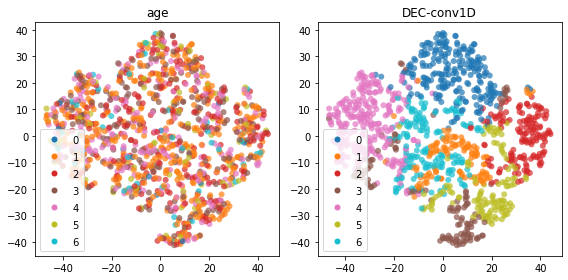

In [21]:
rl_method = "DEC-conv1D"
clust_method = "K-Means"

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and pretrain AE
    print(f"K={k} - Pretraining AE", end=" ")
    encoder = get_encoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
    decoder = get_decoder(INPUT_DIM, LATENT_DIM, FILTERS, KERNEL)
    z = encoder(encoder.inputs)
    ae_outputs = decoder(z)
    model_ae = models.Model(encoder.inputs, ae_outputs)
    
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                     momentum=MOMENTUM_PRETRAIN)
    loss = "mse"
    model_ae.compile(optimizer=optimizer, loss=loss)
    history = model_ae.fit(metabol_exprs, metabol_exprs,
                           epochs=EPOCHS_PRETRAIN,
                           batch_size=BATCH_SIZE,
                           verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
    
    # Construct DEC
    print("- Fine-tunning DEC", end=" ")
    model_dec = get_dec_model(encoder, N_CLUSTERS)
    
    # Initialize parameters
    z_dec = model_dec.encode(metabol_exprs)
    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
    kmeans.fit(z_dec)
    for weight in model_dec.trainable_weights:
        if weight.name == "centroids:0":
            weight.assign(K.constant(kmeans.cluster_centers_))

    p = compute_p(to_categorical(kmeans.labels_))
    c_last = kmeans.labels_

    # Fine-tune the model
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE, 
                                     momentum=MOMENTUM_FINETUNE)
    model_dec.compile(optimizer=optimizer)
    history = model_dec.fit(metabol_exprs, p,
                            epochs=EPOCHS_FINETUNE,
                            batch_size=BATCH_SIZE,
                            callbacks = callback,
                            verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]")
    
    # Compute the cluster assignments
    c_dec = model_dec.classify(metabol_exprs)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_dec})
    
    # Compute metrics
    z_dec = model_dec.encode(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_dec, labels, c_dec, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_dec})
    draw_multiple_labels(z_dec_tsne, labels)